In [1]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
import svgwrite
from IPython.display import SVG, display
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy.matlib
import matplotlib.cm as cm
%matplotlib inline

import math
import cPickle as pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_bounds(data, factor):
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0
    
  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
    
  return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but have to keep same color)
def draw_strokes(data, factor=10, svg_filename = 'sample.svg'):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
    
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

  lift_pen = 1
    
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
    
  command = "m"

  for i in range(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "

  the_color = "black"
  stroke_width = 1

  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))

  dwg.save()
  display(SVG(dwg.tostring()))

In [3]:

class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_ascii_training_data.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print "creating training data cpkl file from raw source"
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print "Parsing dataset..."
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print "======>>>> Line length was too short. Line was: " + ascii
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print "Finished parsing dataset. Saved {} lines".format(len(strokes))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        #[self.raw_stroke_dat, self.raw_ascii_dat] = pickle.load(f)
        #[self.raw_stroke_data, self.raw_ascii_data] = [self.raw_stroke_dat[:50], self.raw_ascii_dat[:50]] 
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print "Loaded dataset:"
        print "   -> {} individual data points".format(len(self.stroke_data))
        print "   -> {} batches".format(self.num_batches)

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in xrange(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print "pointer reset"

In [4]:
batch_size = 5
tsteps = 700
data_scale = 50
U_items = int(tsteps/20)
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, \
                         scale_factor=data_scale, U_items=U_items, alphabet="default")

Loaded dataset:
   -> 3927 individual data points
   -> 785 batches
pointer reset


In [5]:
# in the real project class, we use argparse (https://docs.python.org/3/library/argparse.html)
class FakeArgParse():
    def __init__(self):
        pass
args = FakeArgParse()

#general model params
args.train = False
args.rnn_size = 100 #400 hidden units
args.tsteps = 256 if args.train else 1
args.batch_size = 32 if args.train else 1
args.nmixtures = 8 # number of Gaussian mixtures in MDN

#window params
args.kmixtures = 1 # number of Gaussian mixtures in attention mechanism (for soft convolution window)
args.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' #later we'll add an <UNK> slot for unknown chars
args.tsteps_per_ascii = 25 # an approximate estimate

#book-keeping
args.save_path = './saved/model.ckpt'
args.data_dir = './data'
args.log_dir = './logs/'
args.text = 'Gaurav Gupta'
args.style = -1 # don't use a custom style
args.bias = 1
args.eos_prob = 0.4 # threshold probability for ending a stroke

In [6]:
# in real life the model is a class. I used this hack to make the iPython notebook more readable
class FakeModel():
    def __init__(self):
        pass
model = FakeModel()

In [7]:
model.char_vec_len = len(args.alphabet) + 1 #plus one for <UNK> token
model.ascii_steps = len(args.text)

model.graves_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)
model.window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32)

# ----- build the basic recurrent network architecture
cell_func = tf.contrib.rnn.LSTMCell # could be GRUCell or RNNCell
model.cell0 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
model.cell1 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
model.cell2 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)

model.input_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
model.target_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
model.istate_cell0 = model.cell0.zero_state(batch_size=args.batch_size, dtype=tf.float32)
model.istate_cell1 = model.cell1.zero_state(batch_size=args.batch_size, dtype=tf.float32)
model.istate_cell2 = model.cell2.zero_state(batch_size=args.batch_size, dtype=tf.float32)

#slice the input volume into separate vols for each tstep
inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(model.input_data, args.tsteps, 1)]

#build model.cell0 computational graph
outs_cell0, model.fstate_cell0 = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, model.istate_cell0, \
                                                       model.cell0, loop_function=None, scope='cell0')

In [8]:
# ----- build the gaussian character window
def get_window(alpha, beta, kappa, c):
    # phi -> [? x 1 x ascii_steps] and is a tf matrix
    # c -> [? x ascii_steps x alphabet] and is a tf matrix
    ascii_steps = c.get_shape()[1].value #number of items in sequence
    phi = get_phi(ascii_steps, alpha, beta, kappa)
    window = tf.matmul(phi,c)
    window = tf.squeeze(window, [1]) # window ~ [?,alphabet]
    return window, phi

#get phi for all t,u (returns a [1 x tsteps] matrix) that defines the window
def get_phi(ascii_steps, alpha, beta, kappa):
    # alpha, beta, kappa -> [?,kmixtures,1] and each is a tf variable
    u = np.linspace(0,ascii_steps-1,ascii_steps) # weight all the U items in the sequence
    kappa_term = tf.square( tf.subtract(kappa,u))
    exp_term = tf.multiply(-beta,kappa_term)
    phi_k = tf.multiply(alpha, tf.exp(exp_term))
    phi = tf.reduce_sum(phi_k,1, keep_dims=True)
    return phi # phi ~ [?,1,ascii_steps]

def get_window_params(i, out_cell0, kmixtures, prev_kappa, reuse=True):
    hidden = out_cell0.get_shape()[1]
    n_out = 3*kmixtures
    with tf.variable_scope('window',reuse=reuse):
        window_w = tf.get_variable("window_w", [hidden, n_out], initializer=model.graves_initializer)
        window_b = tf.get_variable("window_b", [n_out], initializer=model.window_b_initializer)
    abk_hats = tf.nn.xw_plus_b(out_cell0, window_w, window_b) # abk_hats ~ [?,n_out] = "alpha, beta, kappa hats"
    abk = tf.exp(tf.reshape(abk_hats, [-1, 3*kmixtures,1]))

    alpha, beta, kappa = tf.split(abk, 3, 1) # alpha_hat, etc ~ [?,kmixtures]
    kappa = kappa + prev_kappa
    return alpha, beta, kappa # each ~ [?,kmixtures,1]

In [9]:
model.init_kappa = tf.placeholder(dtype=tf.float32, shape=[None, args.kmixtures, 1]) 
model.char_seq = tf.placeholder(dtype=tf.float32, shape=[None, model.ascii_steps, model.char_vec_len])
wavg_prev_kappa = model.init_kappa
prev_window = model.char_seq[:,0,:]

#add gaussian window result
reuse = False
for i in range(len(outs_cell0)):
    [alpha, beta, new_kappa] = get_window_params(i, outs_cell0[i], args.kmixtures, wavg_prev_kappa, reuse=reuse)
    window, phi = get_window(alpha, beta, new_kappa, model.char_seq)
    outs_cell0[i] = tf.concat((outs_cell0[i],window), 1) #concat outputs
    outs_cell0[i] = tf.concat((outs_cell0[i],inputs[i]), 1) #concat input data
#         prev_kappa = new_kappa #tf.ones_like(new_kappa, dtype=tf.float32, name="prev_kappa_ones") #
    wavg_prev_kappa = tf.reduce_mean( new_kappa, reduction_indices=1, keep_dims=True) # mean along kmixtures dimension
    reuse = True
model.window = window #save the last window (for generation)
model.phi = phi #save the last window (for generation)
model.new_kappa = new_kappa #save the last window (for generation)
model.alpha = alpha #save the last window (for generation)
model.wavg_prev_kappa = wavg_prev_kappa

In [10]:
# ----- finish building second recurrent cell
outs_cell1, model.fstate_cell1 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell0, model.istate_cell1, model.cell1, \
                                                    loop_function=None, scope='cell1') #use scope from training

# ----- finish building third recurrent cell
outs_cell2, model.fstate_cell2 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell1, model.istate_cell2, model.cell2, \
                                                    loop_function=None, scope='cell2')

out_cell2 = tf.reshape(tf.concat(outs_cell2, 1), [-1, args.rnn_size]) #concat outputs for efficiency

In [11]:
#put a dense cap on top of the rnn cells (to interface with the mixture density network)
n_out = 1 + args.nmixtures * 6 # params = end_of_stroke + 6 parameters per Gaussian
with tf.variable_scope('mdn_dense'):
    output_w = tf.get_variable("output_w", [args.rnn_size, n_out], initializer=model.graves_initializer)
    output_b = tf.get_variable("output_b", [n_out], initializer=model.graves_initializer)

output = tf.nn.xw_plus_b(out_cell2, output_w, output_b) #data flows through dense nn

In [12]:
# ----- build mixture density cap on top of second recurrent cell
def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    x_mu1 = tf.subtract(x1, mu1)
    x_mu2 = tf.subtract(x2, mu2)
    Z = tf.square(tf.div(x_mu1, s1)) + \
        tf.square(tf.div(x_mu2, s2)) - \
        2*tf.div(tf.multiply(rho, tf.multiply(x_mu1, x_mu2)), tf.multiply(s1, s2))
    rho_square_term = 1-tf.square(rho)
    power_e = tf.exp(tf.div(-Z,2*rho_square_term))
    regularize_term = 2*np.pi*tf.multiply(tf.multiply(s1, s2), tf.sqrt(rho_square_term))
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

In [13]:
# now transform dense NN outputs into params for MDN
def get_mdn_coef(Z):
    # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
    eos_hat = Z[:, 0:1] #end of sentence tokens
    pi_hat, mu1_hat, mu2_hat, sigma1_hat, sigma2_hat, rho_hat = tf.split(Z[:, 1:], 6, 1)
    model.pi_hat, model.sigma1_hat, model.sigma2_hat = \
                                        pi_hat, sigma1_hat, sigma2_hat # these are useful for biasing
    
    eos = tf.sigmoid(-1*eos_hat) # technically we gained a negative sign
    pi = tf.nn.softmax(pi_hat) # softmax z_pi:
    mu1 = mu1_hat; mu2 = mu2_hat # leave mu1, mu2 as they are
    sigma1 = tf.exp(sigma1_hat); sigma2 = tf.exp(sigma2_hat) # exp for sigmas
    rho = tf.tanh(rho_hat) # tanh for rho (squish between -1 and 1)

    return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

In [14]:
# reshape target data (as we did the input data)
flat_target_data = tf.reshape(model.target_data,[-1, 3])
[x1_data, x2_data, eos_data] = tf.split(flat_target_data, 3, 1) #we might as well split these now
[model.eos, model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.rho] = get_mdn_coef(output)

In [15]:
model.sess = tf.InteractiveSession()
model.saver = tf.train.Saver(tf.global_variables())
model.sess.run(tf.global_variables_initializer())

load_was_success = True # yes, I'm being optimistic
global_step = 0
try:
    save_dir = '/'.join(args.save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    model.saver.restore(model.sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    model.saver = tf.train.Saver(tf.global_variables())
    global_step = int(load_path.split('-')[-1])

INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-110500


INFO:tensorflow:Restoring parameters from ./saved/model.ckpt-110500


loaded model: ./saved/model.ckpt-110500


In [16]:
# utility function for converting input ascii characters into vectors the network can understand.
# index position 0 means "unknown"
def to_one_hot(s, ascii_steps, alphabet):
    steplimit=3e3; s = s[:3e3] if len(s) > 3e3 else s # clip super-long strings
    seq = [alphabet.find(char) + 1 for char in s]
    if len(seq) >= ascii_steps:
        seq = seq[:ascii_steps]
    else:
        seq = seq + [0]*(ascii_steps - len(seq))
    one_hot = np.zeros((ascii_steps,len(alphabet)+1))
    one_hot[np.arange(ascii_steps),seq] = 1
    return one_hot

In [17]:
def get_style_states(model, args):
    with open(os.path.join(args.data_dir, 'styles.p'),'r') as f:
        style_strokes, style_strings = pickle.load(f)

    style_strokes, style_string = style_strokes[args.style], style_strings[args.style]
    style_onehot = [to_one_hot(style_string, model.ascii_steps, args.alphabet)]

    c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
    h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
    if args.style is -1: return [c0, c1, c2, h0, h1, h2] #model 'chooses' random style
        
    style_stroke = np.zeros((1, 1, 3), dtype=np.float32)
    style_kappa = np.zeros((1, args.kmixtures, 1))
    prime_len = 500 # must be <= 700
    
    for i in xrange(prime_len):
        style_stroke[0][0] = style_strokes[i,:]
        feed = {model.input_data: style_stroke, model.char_seq: style_onehot, model.init_kappa: style_kappa, \
                model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
        fetch = [model.wavg_prev_kappa, \
                 model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,
                 model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
        [style_kappa, c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)
    return [c0, c1, c2, np.zeros_like(h0), np.zeros_like(h1), np.zeros_like(h2)] #only the c vectors should be primed

In [18]:
# initialize some sampling parameters
one_hot = [to_one_hot(args.text, model.ascii_steps, args.alphabet)]  # convert input string to one-hot vector
kappa = np.zeros((1, args.kmixtures, 1))                              # attention's read head starts at index 0
prev_x = np.asarray([[[0, 0, 1]]], dtype=np.float32)                  # start with a pen stroke at (0,0)

strokes, pis, windows, phis, kappas = [], [], [], [], []              # the data we're going to generate will go here
[c0, c1, c2, h0, h1, h2] = get_style_states(model, args)              # get numpy zeros states for all three LSTMs


In [19]:
def sample_gaussian2d(mu1, mu2, s1, s2, rho):
    mean = [mu1, mu2]
    cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

In [20]:
finished = False ; i = 0
while not finished and i < 800:
    feed = {model.input_data: prev_x, model.char_seq: one_hot, model.init_kappa: kappa, \
            model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
            model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
    fetch = [model.pi_hat, model.mu1, model.mu2, model.sigma1_hat, model.sigma2_hat, model.rho, model.eos, \
             model.window, model.phi, model.new_kappa, model.wavg_prev_kappa, model.alpha, \
             model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,\
             model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
    [pi_hat, mu1, mu2, sigma1_hat, sigma2_hat, rho, eos, window, phi, kappa, wavg_kappa, alpha, \
             c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)
    
    #bias stuff:
    sigma1 = np.exp(sigma1_hat - args.bias)
    sigma2 = np.exp(sigma2_hat - args.bias)
    pi_hat *= 1 + args.bias # apply bias
    pi = np.zeros_like(pi_hat) # need to preallocate
    pi[0] = np.exp(pi_hat[0]) / np.sum(np.exp(pi_hat[0]), axis=0) # softmax
    
    # choose a component from the MDN
    idx = np.random.choice(pi.shape[1], p=pi[0])
    eos = 1 if args.eos_prob < eos[0][0] else 0 # use 0.5 as arbitrary boundary
    x1, x2 = sample_gaussian2d(mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx])
        
    # store the info at this time step
    windows.append(window)
    phis.append(phi[0])
    kappas.append(kappa[0])
    pis.append(pi[0])
    strokes.append([mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx], eos])
    
    # test if finished (has the read head seen the whole ascii sequence?)
    main_kappa_idx = np.where(alpha[0]==np.max(alpha[0])); # choose the read head with the highes alpha value
    finished = True if kappa[0][main_kappa_idx] > len(args.text) + 1 else False
    
    # new input is previous output
    prev_x[0][0] = np.array([x1, x2, eos], dtype=np.float32)
    kappa = wavg_kappa
    i+=1
windows = np.vstack(windows)
phis = np.vstack(phis)
kappas = np.vstack(kappas)
pis = np.vstack(pis)
strokes = np.vstack(strokes)

# the network predicts the displacements between pen points, so do a running sum over the time dimension
strokes[:,:2] = np.cumsum(strokes[:,:2], axis=0)

/home/gaurav/Desktop/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


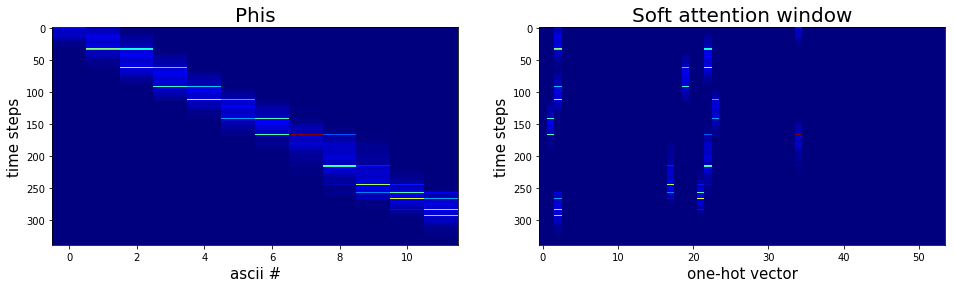

In [21]:
# plots parameters from the attention mechanism
def window_plots(phis, windows):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("ascii #", fontsize=15)
    plt.ylabel("time steps", fontsize=15)
    plt.imshow(phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("one-hot vector", fontsize=15)
    plt.ylabel("time steps", fontsize=15)
    plt.imshow(windows, interpolation='nearest', aspect='auto', cmap=cm.jet)
    
window_plots(phis, windows)

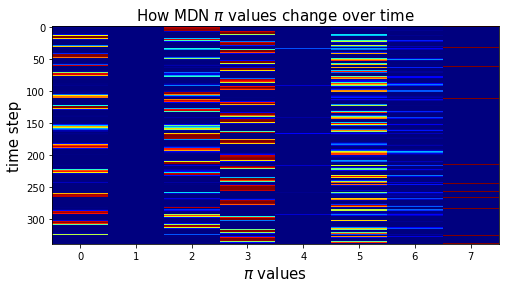

In [22]:
plt.figure(figsize=(8,4))
plt.title("How MDN $\pi$ values change over time", fontsize=15)
plt.xlabel("$\pi$ values", fontsize=15)
plt.ylabel("time step", fontsize=15)
plt.imshow(pis, interpolation='nearest', aspect='auto', cmap=cm.jet)

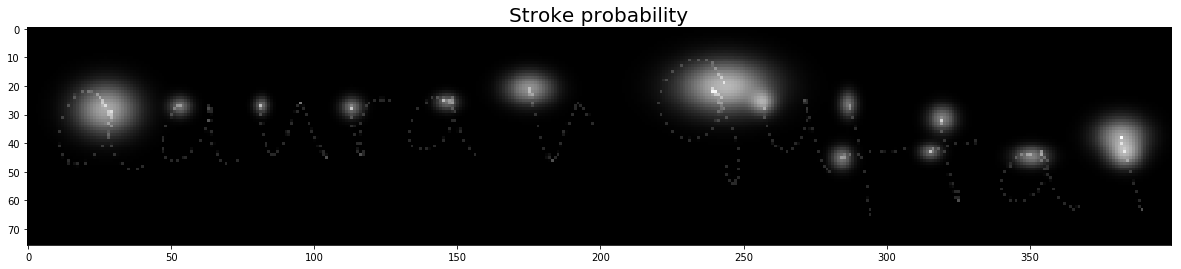

In [23]:
def gauss_plot(strokes, title, figsize = (20,2)):
    plt.figure(figsize=figsize)
    import matplotlib.mlab as mlab
    buff = 1 ; epsilon = 1e-4
    minx, maxx = np.min(strokes[:,0])-buff, np.max(strokes[:,0])+buff
    miny, maxy = np.min(strokes[:,1])-buff, np.max(strokes[:,1])+buff
    delta = abs(maxx-minx)/400. ;

    x = np.arange(minx, maxx, delta)
    y = np.arange(miny, maxy, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(strokes.shape[0]):
        gauss = mlab.bivariate_normal(X, Y, mux=strokes[i,0], muy=strokes[i,1], \
            sigmax=strokes[i,2], sigmay=strokes[i,3], sigmaxy=0) # sigmaxy=strokes[i,4] gives error
        Z += gauss * np.power(strokes[i,3] + strokes[i,2], .4) / (np.max(gauss) + epsilon)

    plt.title(title, fontsize=20)
    plt.imshow(Z)
    
gauss_plot(strokes, "Stroke probability", figsize = (2*model.ascii_steps,4))

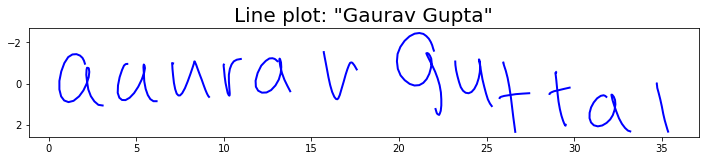

In [24]:
# plots the stroke data (handwriting!)
def line_plot(strokes, title, figsize = (20,2)):
    plt.figure(figsize=figsize)
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0) #draw a stroke
    plt.title(title,  fontsize=20)
    plt.gca().invert_yaxis()
    plt.show()
    
line_plot(strokes, 'Line plot: "{}"'.format(args.text), figsize=(model.ascii_steps,2))